In [5]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
import scipy.stats as stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 7.5, 7.5

Aditya Kharosekar amk3587
Rahul Jain rj8656

# Problem 1

In [6]:
mean1 = [0, 0, 0]
covMatrix1 = [[1, 0.9, 0.9], [0.9, 1, 0.9], [0.9, 0.9, 1]]

mean2 = [0, 0, 1]
covMatrix2 = [[1, 0.8, 0.8], [0.8, 1, 0.8], [0.8, 0.8, 1]]

first = np.random.multivariate_normal(mean1, covMatrix1, 20)
second = np.random.multivariate_normal(mean2, covMatrix2, 20)

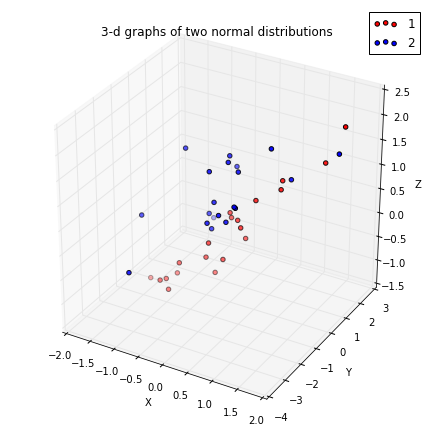

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(first[:,0], first[:,1], zs = first[:,2], c="r", label="1")
ax.scatter(second[:,0], second[:,1], zs = second[:,2], c="b", label="2")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
legend = ax.legend(loc="upper right")
plt.title("3-d graphs of two normal distributions")
plt.show()

## Part 2

In [8]:
def calcFischer(first, second, title):
    mean1 = [np.mean(first[:,0]), np.mean(first[:,1]),np.mean(first[:,2])]
    mean2 = [np.mean(second[:,0]), np.mean(second[:,1]),np.mean(second[:,2])]

    #Calculating between variance (Sb)
    difference = np.subtract(mean2, mean1)
    difference = np.reshape(difference, (3,1))
    Sb = np.dot(difference, np.transpose(difference))


    #Calculating within variance (Sw)
    sumFirst = 0.0
    sumSecond = 0.0

    for point in first:
        difference = np.subtract(point, mean1)
        difference = np.reshape(difference, (3,1))
        sumFirst += np.dot(difference, np.transpose(difference))

    for point in second:
        difference = np.subtract(point, mean2)
        difference = np.reshape(difference, (3,1))
        sumSecond += np.dot(difference, np.transpose(difference))

    Sw = np.add(sumFirst, sumSecond)
    newMatrix = np.dot(np.linalg.inv(Sw), Sb)
    U, s, V = np.linalg.svd(newMatrix, compute_uv = True)
    V[0] #This is the eigenvector related to the largest eigenvalue
    # We need to project the data onto this vector
    
    newaxis = V[0]
    newaxis = np.reshape(newaxis, (3,1))
    newprojection1 = np.dot(first, newaxis)
    newprojection2 = np.dot(second, newaxis)
    y = np.zeros(20)

    plt.scatter(newprojection1, y, c="r", label = "1")
    plt.scatter(newprojection2, y, c="b", label = "2")
    plt.legend(loc = "upper right")
    plt.title(title)
    plt.show()

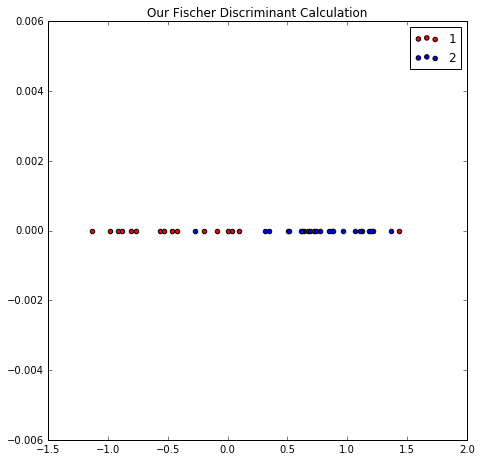

In [9]:
calcFischer(first, second,"Our Fischer Discriminant Calculation")

## Part c

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
X = np.concatenate((first, second))
y1 = np.ones((20,))
y2 = np.multiply(np.ones((20,)), 2)
y = np.concatenate((y1, y2))
clf.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

We need to test the inbuilt LDA function with the calculations that we did by hand. For this, I will create two new random sets of data points.

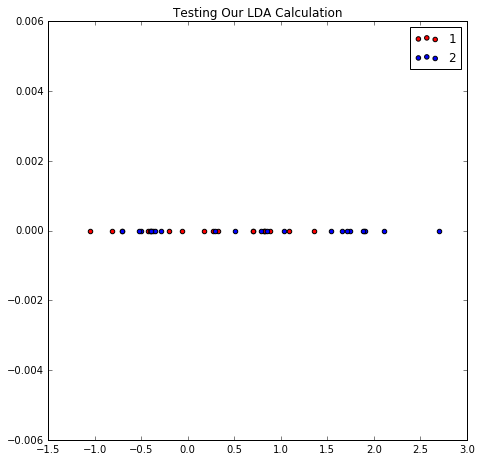

In [11]:
d1 = np.random.multivariate_normal(mean1, covMatrix1, 20)
d2 = np.random.multivariate_normal(mean2, covMatrix2, 20)
d = np.concatenate((d1, d2))

testValues1 = np.ones((20,))
testValues2 = np.multiply(np.ones((20,)), 2)
testValues = np.concatenate((testValues1, testValues2))
calcFischer(d1, d2, "Testing Our LDA Calculation")

On these two new datasets, our calculated Fischer Discriminant leads to the above projection.

From inspection, it seems that a value of approximately 0 to -0.5 on the horizontal axis is the dividing line between the two datasets. If we used this model, we would say that to the right of this line would be the second dataset and to the left is the first dataset. 

Let's see how that compares with the scikit-learn inbuilt implementation of Linear Discriminant Analysis.

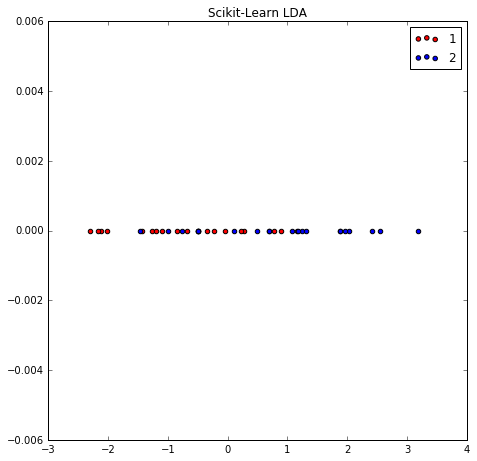

In [12]:
inbuiltResults = clf.transform(d)
plt.scatter(inbuiltResults[:20], np.reshape(np.zeros(20), (20,1)), c="r", label="1")
plt.scatter(inbuiltResults[20:], np.reshape(np.zeros(20), (20,1)), c="b", label="2")
plt.legend(loc = "upper right")
plt.title("Scikit-Learn LDA")
plt.show()

From inspection, we can see that even in this graph, which represents the projection of the data points in the direction calculated by the scikit-learn implementation of LDA, the dividing line seems to be approximately -0.5 on the horizontal axis.

Therefore, the inbuilt implementation of LDA and our calculated version agree with each other.

# Problem 2

In [13]:
data1 = pd.read_csv("CorrMat1.csv", header=None)
data3 = pd.read_csv("CorrMat3.csv", header=None)


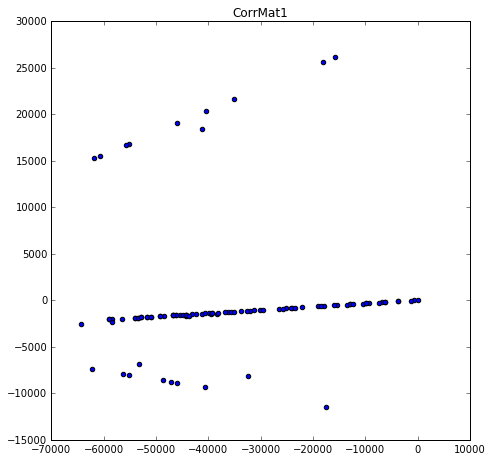

In [14]:
mat1 = np.matrix(data1)
u, s, v = np.linalg.svd(data1)

evectors = np.matrix(np.transpose([v[0], v[1]]))

newMatrix = np.dot(mat1, evectors)
plt.scatter(newMatrix[:,0], newMatrix[:,1], c = "b")
plt.title("CorrMat1")
plt.show()


In an attempt to find the corrupted data, we did PCA to transform the graph into 2D. We see a pattern in the graph. 

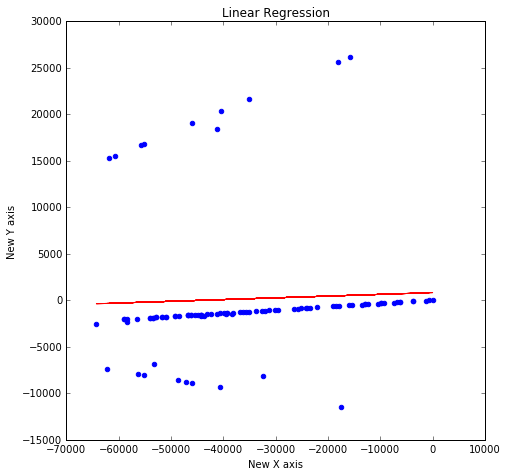

In [15]:
regr = linear_model.LinearRegression()
regr.fit(newMatrix[:,0], newMatrix[:,1])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(newMatrix[:,0], newMatrix[:,1], color="blue")
ax.plot(newMatrix[:,0], regr.predict(newMatrix[:,0]), color="red")
ax.set_xlabel("New X axis")
ax.set_ylabel("New Y axis")
ax.set_title("Linear Regression")
plt.show()

We assumed that everything not on the main blue line is "corrupt" data. We will now fix the corrupt data by moving each corrupt point's Y value to match the linear regression value. We will leave the X value the same.

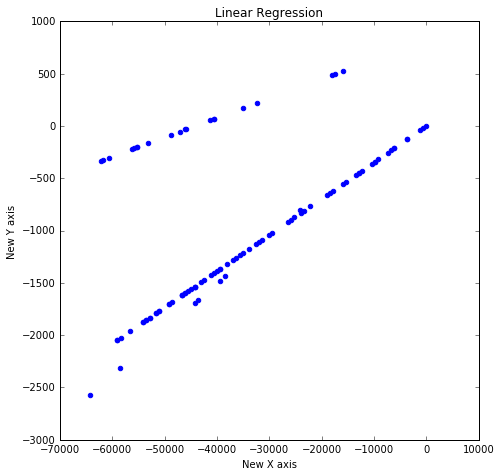

In [16]:

X = newMatrix[:,0]
Y= newMatrix[:,1]
for i in range(len(Y)):
    if(Y[i]<-5000 or Y[i]>10000):
        Y[i] = regr.intercept_ + regr.coef_*X[i]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X,Y, color="blue")
ax.set_xlabel("New X axis")
ax.set_ylabel("New Y axis")
ax.set_title("Linear Regression")
plt.show()

Notice the scaling on the new graph; the points are a lot closer together than the original graph. Thus, the corrupt points are "less" corrupt now. 

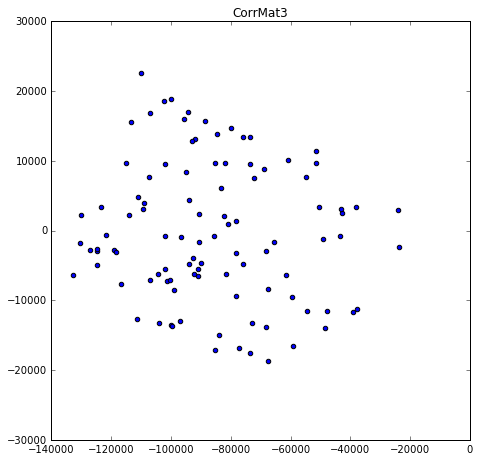

In [17]:
mat3 = np.matrix(data3)
u, s, v = np.linalg.svd(data3)

evectors = np.matrix(np.transpose([v[0], v[1]]))

newMatrix3 = np.dot(mat3, evectors)
plt.scatter(newMatrix3[:,0], newMatrix3[:,1], c = "b")
plt.title("CorrMat3")
plt.show()

We can't see any interesting patterns in this graph; let's try seeing what the image looks like for corrmatrix3. 

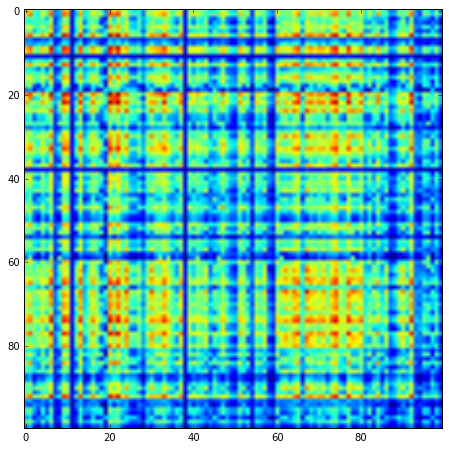

In [18]:
plt.imshow(data3)


The red values seem out of place; let's see if we can figure out why. 

In [19]:
print(mat3)

[[ 11961.  13479.   9106. ...,   5626.   9200.   5082.]
 [ 13479.  16106.   8784. ...,   7134.  10700.   6553.]
 [  9106.   8784.   9324. ...,   2840.   6534.   2582.]
 ..., 
 [  5626.   7134.   2840. ...,   6376.   3382.   2264.]
 [  9200.  10700.   6534. ...,   3382.   7697.   4550.]
 [  5082.   6553.   2582. ...,   2264.   4550.   3137.]]


It seems that matr3[row][column] = mat3[column][row]. Maybe the corrupted points dont follow this pattern. 

In [20]:
count = 0
count2 = 0
for i in range(0,100): 
    for x in range(0,100):
        if data3[i][x] == data3[x][i]:
            count+=1
        count2+=1
print( count/count2)

0.9802


98% of values follow the pattern.  

In [21]:
for i in range(0,50): 
    for x in range(0,50):
        if data3[i][x] != data3[x][i]:
            print (data3[i][x], data3[x][i])
        


9999.0 17259.0
9999.0 12143.0
9999.0 7909.0
9999.0 13240.0
9999.0 12361.0
9999.0 19364.0
9999.0 14148.0
9999.0 11273.0
9999.0 14743.0
9999.0 14238.0
9999.0 8507.0
9999.0 6499.0
9999.0 6653.0
9999.0 6052.0
9999.0 5821.0
17259.0 9999.0
19364.0 9999.0
8507.0 9999.0
15404.0 9999.0
14366.0 9999.0
13605.0 9999.0
11422.0 9999.0
12143.0 9999.0
14148.0 9999.0
6499.0 9999.0
11505.0 9999.0
11196.0 9999.0
10308.0 9999.0
8253.0 9999.0
7909.0 9999.0
11273.0 9999.0
6653.0 9999.0
8424.0 9999.0
10043.0 9999.0
8438.0 9999.0
6081.0 9999.0
13240.0 9999.0
14743.0 9999.0
6052.0 9999.0
13205.0 9999.0
12169.0 9999.0
11336.0 9999.0
8848.0 9999.0
9999.0 15404.0
9999.0 11505.0
9999.0 8424.0
9999.0 13205.0
9999.0 14165.0
9999.0 14366.0
9999.0 11196.0
9999.0 10043.0
9999.0 12169.0
9999.0 13458.0
9999.0 13605.0
9999.0 10308.0
9999.0 8438.0
9999.0 11336.0
9999.0 12100.0
9999.0 11422.0
9999.0 8253.0
9999.0 6081.0
9999.0 8848.0
9999.0 8563.0
12361.0 9999.0
14238.0 9999.0
5821.0 9999.0
14165.0 9999.0
13458.0 9999.0
121

Corrupted points always contain value 9999.0. Try changing the 9999.0 to the matching pair value. 

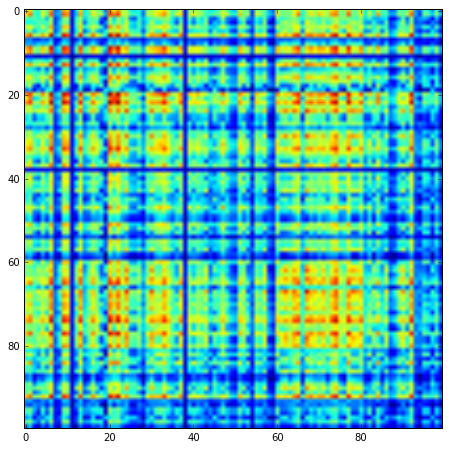

In [22]:
for i in range(0,100): 
    for x in range(0,100):
        if data3[i][x] != data3[x][i]:
            if(data3[i][x] == 9999.0):
                data3[i][x] = data3[x][i]
            else: 
                data3[x][i] = data3[i][x]
plt.imshow(data3)


In [75]:
count = 0 
count2 = 0 
for i in range(0,100): 
    for x in range(0,100):
        if data3[i][x] == data3[x][i]:
            count+=1
        count2+=1
print( count/count2 * 100, "% follows pattern")

100.0 % follows pattern


The image didnt change much, but at least all points now follor the pattern of mat3[i][j] = mat3[j][i]. Perhaps the image wasn't really showing the corrupted points. 

# Problem 3

## First, some data preprocessing.
https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

In [24]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [25]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [26]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [27]:
rcParams['figure.figsize'] = 12.0, 6.0
prices = pd.DataFrame({"Price:": train["SalePrice"], "log(price+1)": np.log1p(train["SalePrice"])})
prices.head()

,Price:,log(price+1)
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


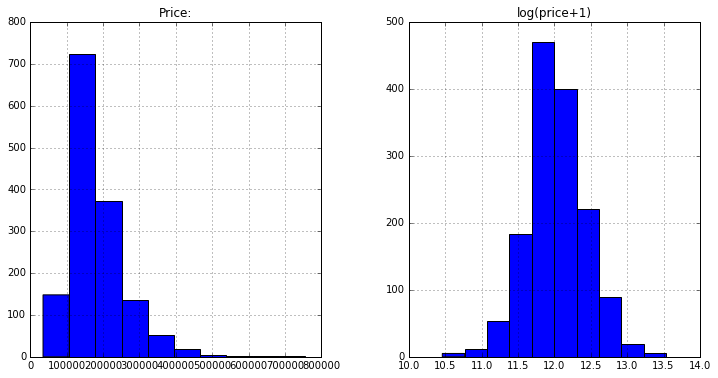

In [28]:
prices.hist()
plt.show()

In [29]:
#Removing the ID column
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [30]:
all_data = pd.get_dummies(all_data) #creates dummy variables
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [32]:
all_data.shape

(2919, 288)

Done with all preprocessing as found on kaggle. Fixed the missing values and added dummy variables. Now we will run a ridge regression on different alphas: 

In [33]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
X_train_final = all_data[:train.shape[0]]
X_test_final = all_data[train.shape[0]:]
y = train.SalePrice


In [34]:
def rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = "mean_squared_error", cv = 5))
    return rmse

In [35]:
model_Ridge = Ridge()

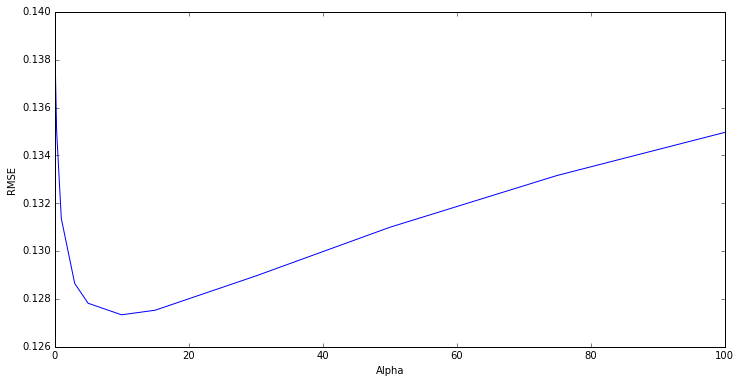

In [36]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100]
cv_ridge = [rmse(Ridge(alpha = a)).mean() for a in alphas]
cv_ridge=pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

From the above graph, an alpha of 10 is best to minimize RMSE

In [37]:
cv_ridge.min()

0.12733734668670763

### Lasso

In [38]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.005]).fit(X_train, y)

In [39]:
rmse(model_lasso).mean()

0.12419498942266938

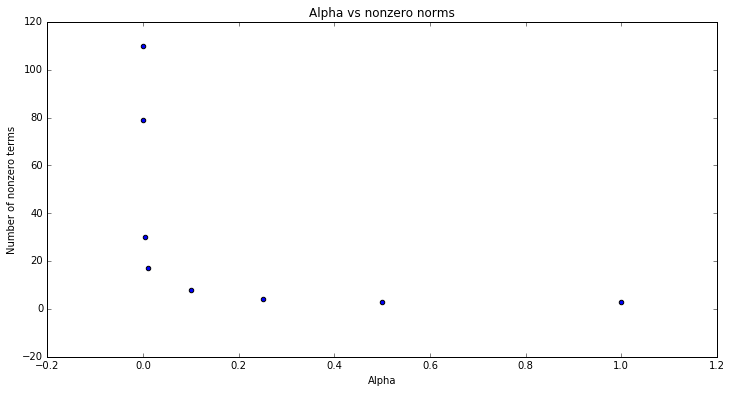

In [40]:
alphas = [1, 0.5, 0.25, 0.1, 0.01, 0.005, 0.001, 0.0005]

nonzero_norms = []
for alpha in alphas:
    model = Lasso(alpha).fit(X_train, y)
    coefs = model.coef_
    count = 0.0
    for coef in coefs:
        if coef!=0:
            count = count+1
    nonzero_norms.append(count)
plt.scatter(alphas, nonzero_norms)
plt.xlabel("Alpha")
plt.ylabel("Number of nonzero terms")
plt.title("Alpha vs nonzero norms")
plt.show()

### Ensembling and Stacking
We will add on the predictions of a Lasso and a Ridge model as features to the data set, then run a Ridge on the new data set. 

In [41]:
new_ridge_model = Ridge(alpha = 10)
new_ridge_model.fit(X_train, y)
ridge_results = new_ridge_model.predict(X_train)
ridge_results

array([ 12.24391057,  12.17892855,  12.28836396, ...,  12.43402032,
        11.85310649,  11.85860895])

In [42]:
lasso = model_lasso.predict(X_train)

In [43]:
X_train["Ridge"] = ridge_results
X_train["Lasso"] = lasso

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [44]:
model_Ridge = RidgeCV(alphas = [0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10, 15, 30,50, 75, 100])
model_Ridge.fit(X_train, y)

RidgeCV(alphas=[0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10, 15, 30, 50, 75, 100],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [45]:
ridge_score = -cross_val_score(model_Ridge, X_train, y, scoring = "mean_squared_error", cv = 5)

In [46]:
print(np.sqrt(ridge_score).mean())

0.125304467832


By stacking and running the ridge, we got RMSE of .125

### XGBoost

In [47]:
import xgboost as xgb
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

In [48]:
parameters = {
    'max_depth':[1, 2, 6, 8, 10],
    'n_estimators':[25, 50, 100, 150, 200],
    'reg_alpha' : [0.001, 0.05, 0.1, 0.25, 0.5]
}

xgmodel = xgb.XGBRegressor()
xg_clf = GridSearchCV(xgmodel, parameters, cv = 5, scoring = "mean_squared_error").fit(X_train, y)

In [49]:
print(np.sqrt(-xg_clf.best_score_))

0.109467093367


In [50]:
xg_clf2 = RandomizedSearchCV(xgmodel, parameters, cv=5, scoring = "mean_squared_error").fit(X_train, y)
print(np.sqrt(-xg_clf2.best_score_))

0.11034556978


In [51]:
print(xg_clf.best_params_)
print(xg_clf2.best_params_)

{'n_estimators': 200, 'reg_alpha': 0.001, 'max_depth': 1}
{'n_estimators': 150, 'reg_alpha': 0.1, 'max_depth': 1}


XGBoost gave RMSE on the train data of .109 when we used a GridSearch cross validation and alpha of .001

## Part 6
We will try stacking 4 models on the data: xgboost, lasso, Ridge, and random forest. 
(Idea from kaggle comments) 

In [52]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Ridge,Lasso
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.243911,12.247563
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.178929,12.162937
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.288364,12.304561
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,12.033395,12.076531
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.607881,12.624928


In [53]:
X_train_new = X_train.ix[:,:-2]
X_train_new.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
xgmodel = xgb.XGBRegressor(n_estimators = 200, reg_alpha = .001, max_depth = 1)
xg_clf_new = xgmodel.fit(X_train_new, y) # training the xgboost

In [55]:
#training the random forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(X_train_new, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [56]:
X_train["XGBoost"] = xg_clf_new.predict(X_train_new)

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
X_train["Forest"] = forest.predict(X_train_new)

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Ridge,Lasso,XGBoost,Forest
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,12.243911,12.247563,12.219547,12.260876
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,12.178929,12.162937,12.056585,12.081497
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,12.288364,12.304561,12.249222,12.299473
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,12.033395,12.076531,12.112557,11.988998
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,12.607881,12.624928,12.637372,12.472816


In [59]:
X_test_new = X_test.copy()

In [60]:
X_test_new.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.044522,4.394449,9.360741,5,6,1961,1961,0.000000,6.150603,4.976734,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.406719,9.565775,6,6,1958,1958,4.691348,6.828712,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.317488,9.534668,5,5,1997,1998,0.000000,6.674561,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.110874,4.369448,9.208238,6,6,1998,1998,3.044522,6.401917,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.795791,3.784190,8.518392,8,5,1992,1992,0.000000,5.575949,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
X_test["Ridge"] = new_ridge_model.predict(X_test_new)
X_test_new.shape

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(1459, 288)

In [62]:
X_test["Lasso"] = model_lasso.predict(X_test_new)

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [63]:
X_test["XGBoost"] = xg_clf_new.predict(X_test_new)
X_test["Forest"] = forest.predict(X_test_new)

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [64]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Ridge,Lasso,XGBoost,Forest
0,3.044522,4.394449,9.360741,5,6,1961,1961,0.000000,6.150603,4.976734,...,0.0,0.0,0.0,0.0,1.0,0.0,11.687132,11.688996,11.698003,11.788645
1,3.044522,4.406719,9.565775,6,6,1958,1958,4.691348,6.828712,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,11.938427,11.920107,11.934022,11.927906
2,4.110874,4.317488,9.534668,5,5,1997,1998,0.000000,6.674561,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,12.106320,12.098437,12.098293,12.131724
3,4.110874,4.369448,9.208238,6,6,1998,1998,3.044522,6.401917,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,12.195477,12.207331,12.124110,12.088009
4,4.795791,3.784190,8.518392,8,5,1992,1992,0.000000,5.575949,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,12.207617,12.213619,12.196935,12.193618


We have added the predictions of our four models as features. Now we will run a XGBRegression on the new data set. 

In [65]:
xgmodel = xgb.XGBRegressor(n_estimators = 200, reg_alpha = .001, max_depth = 1)
xg_clf_new = xgmodel.fit(X_train, y) # training the xgboost

In [66]:
results = np.expm1(xg_clf_new.predict(X_test))

In [67]:
submission = pd.DataFrame({"Id":test.Id, "SalePrice":results})

In [68]:
submission.head()

,Id,SalePrice
0,1461,128922.000000
1,1462,153173.187500
2,1463,185173.531250
3,1464,177271.359375
4,1465,194527.375000


In [69]:
submission.to_csv('submission1.csv', index= False)

This submission had an RMSE of 0.14698 for a rank of 2888.

## Try optimized LASSO
In an attempt to improve our rank on kaggle, lets just try to use a simple Lasso with optimized alpha. 

In [70]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.005,.025, .002, .0001, .05]).fit(X_train_final, y)

In [71]:
results2 = np.expm1( model_lasso.predict(X_test_final))

In [72]:
submission = pd.DataFrame({"Id":test.Id, "SalePrice":results2})

In [73]:
submission.to_csv('submission2.csv', index= False)

In [74]:
submission.head()

,Id,SalePrice
0,1461,119251.221114
1,1462,150256.759467
2,1463,179589.907042
3,1464,200250.739786
4,1465,201513.989979


This submission had a RMSE of .12239, placing us #1359. Kaggle name: AdiJain